numero de pontos do dataset:  (7200,)
primeiro ponto da série de teste:  5760
trainX.shape=  (159, 33, 1)
trainY.shape=  (159, 3)
testX.shape=  (39, 33, 1)
testY.shape=  (39, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 9)                 99        
                                                                 
 dense (Dense)               (None, 3)                 30        
                                                                 
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________
None
train erro=  0.0004845442061170861
test erro=  0.002237767699282445


Text(0.5, 1.0, 'Valores verdadeiros e previstos para o final das séries. A linha separa os dados de treinamento e teste.')

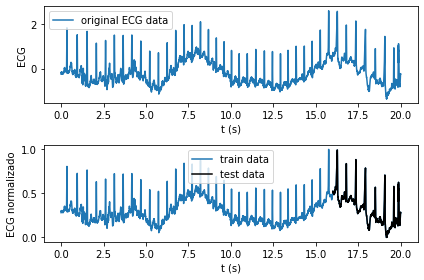

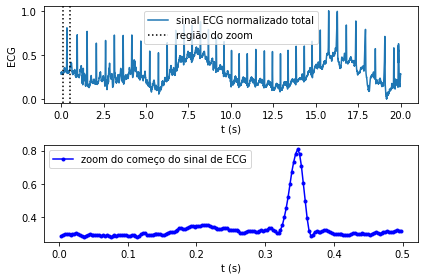

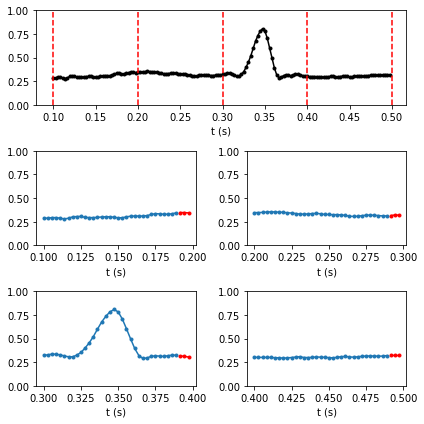

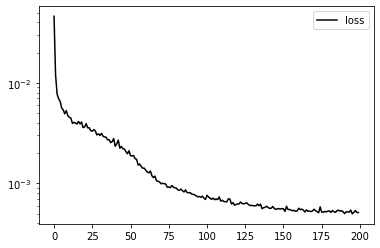

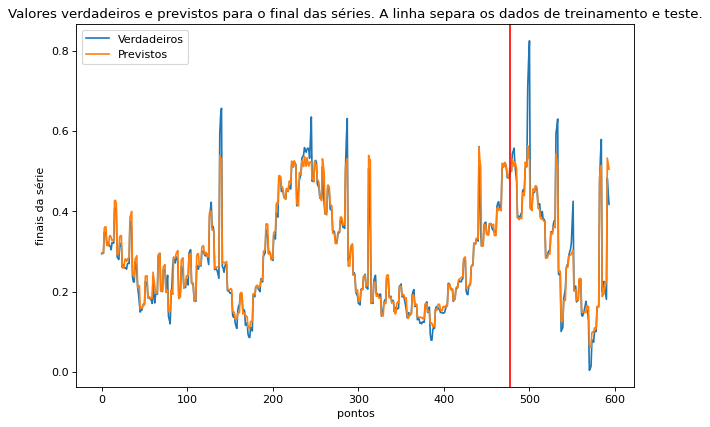

In [1]:
#https://machinelearningmastery.com/understanding-simple-recurrent-neural-networks-in-keras/
#https://www.tensorflow.org/guide/keras/rnn

#Esse código divide o ECG em janelas de Npontos
#cada janela é dividida para um começo de treino e cabe a rede
#prever o valor dos últimos Npred pontos.

#importa as bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.misc import electrocardiogram


#importa e normaliza o dataset,no caso, um ECG do scipy.misc
Fs=360
ECG = electrocardiogram()[0:20*Fs]
t = np.arange(0,len(ECG))/Fs
#ECG=np.sin(t)
#normaliza o sinal para entre 0 e 1!
sinal=(ECG-np.min(ECG))/np.max(ECG-np.min(ECG))
print("numero de pontos do dataset: ",sinal.shape)

#dividi a série, o começo para Dtrain e o final para Dtest
parc_data_train=0.8
split = int(len(sinal)*parc_data_train)
train_sinal = sinal[0:split]
test_sinal = sinal[split:]
print("primeiro ponto da série de teste: ",split)

Npontos=36 #defini o tamanho total das janelas (entradas + saídas)
Npred=3 #defini o tamanho das saídas

def cria_IN_OUT(data, janela):
    OUT_indices = np.arange(janela, len(data), janela)
    OUT = data[OUT_indices]
    lin_x = len(OUT)
    IN = data[range(janela*len(OUT))]
    IN = np.reshape(IN, (len(OUT), janela, 1))    
    OUT_final = IN[:,-Npred:,0]
    IN_final = IN[:,:-Npred,:]
    return IN_final, OUT_final
trainX, trainY = cria_IN_OUT(train_sinal, Npontos)
testX, testY = cria_IN_OUT(test_sinal, Npontos)
print('trainX.shape= ',trainX.shape)
print('trainY.shape= ',trainY.shape)
print('testX.shape= ',testX.shape)
print('testY.shape= ',testY.shape)

#Figuras
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,ECG,label='original ECG data');plt.xlabel('t (s)');plt.ylabel('ECG')
plt.legend()
plt.subplot(2,1,2)
plt.plot(t,sinal,label='train data');plt.xlabel('t (s)');plt.ylabel('ECG normalizado')
plt.plot(t[split:],test_sinal,'k',label='test data')
plt.legend()
plt.tight_layout()

plt.figure()
plt.subplot(2,1,1)
plt.plot(t,sinal,label='sinal ECG normalizado total');
plt.xlabel('t (s)');plt.ylabel('ECG')
plt.axvline(0.1,ls=':',c='k');
plt.axvline(0.5,ls=':',c='k',label='região do zoom');
plt.legend()
plt.subplot(2,1,2)
plt.plot(t[1:5*(Npontos)],sinal[1:5*(Npontos)],'b.-',label='zoom do começo do sinal de ECG');
plt.xlabel('t (s)');
plt.legend()
plt.tight_layout()

plt.figure(figsize=(6,6))
plt.subplot(3,1,1)
plt.plot(t[Npontos:5*(Npontos)],sinal[Npontos:5*(Npontos)],'k.-');plt.xlabel('t (s)');
for n in range(1,6):
  plt.axvline(t[Npontos*n],ls='--',c='r')
plt.ylim(0,1)
for n in range(1,5):
  plt.subplot(3,2,n+2)
  plt.plot(t[n*(Npontos):(n)*Npontos+(Npontos-Npred)],trainX[n,:,0],'.-');
  plt.plot(t[(n)*Npontos+(Npontos-Npred):(n+1)*Npontos],trainY[n,:],'r.-');
  plt.xlabel('t (s)');plt.ylim(0,1)
plt.tight_layout()

#cria uma rede recorrente com 1 camada recorrente e 1 densa.
def cria_RNN(hidden_units, dense_units, input_shape, activation):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.SimpleRNN(hidden_units, input_shape=input_shape, 
                        activation=activation[0]))
    model.add(tf.keras.layers.Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
model = cria_RNN(hidden_units=9, dense_units=Npred, 
      input_shape=(Npontos-Npred,1), activation=['relu', 'sigmoid'])
print(model.summary())
#treina a rede e mostra o gráfico do loss
history=model.fit(trainX, trainY , epochs=200, batch_size=1, verbose=0)
plt.figure()
plt.plot(history.history['loss'],'k')
plt.yscale('log')
plt.legend(['loss'])

#faz previsões e calcula os erros
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
train_msre=np.mean((train_predict-trainY)**2)
test_msre=np.mean((test_predict-testY)**2)
print('train erro= ',train_msre);print('test erro= ',test_msre)

# gráfico dos valores verdadeiros com os previstos
finais_verdadeiros = np.append(trainY, testY)
predictions = np.append(train_predict, test_predict)
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(finais_verdadeiros)
plt.plot(predictions)
plt.axvline(len(trainY)*Npred, color='r')
plt.legend(['Verdadeiros', 'Previstos'])
plt.xlabel('pontos')
plt.ylabel('finais da série')
plt.title('Valores verdadeiros e previstos para o final das séries. A linha separa os dados de treinamento e teste.')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 33, 9)             99        
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 4)                 56        
                                                                 
 dense_1 (Dense)             (None, 3)                 15        
                                                                 
 dense_2 (Dense)             (None, 3)                 12        
                                                                 
Total params: 182
Trainable params: 182
Non-trainable params: 0
_________________________________________________________________
None
len=  (159, 3)
train erro=  0.00026590283120286114
test erro=  0.001732953635562176


Text(0.5, 1.0, 'Valores verdadeiros e previstos para o final das séries. A linha separa os dados de treinamento e teste.')

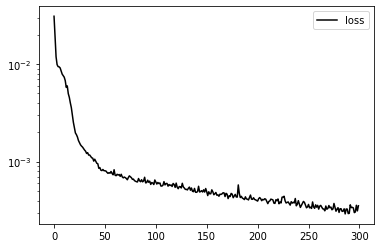

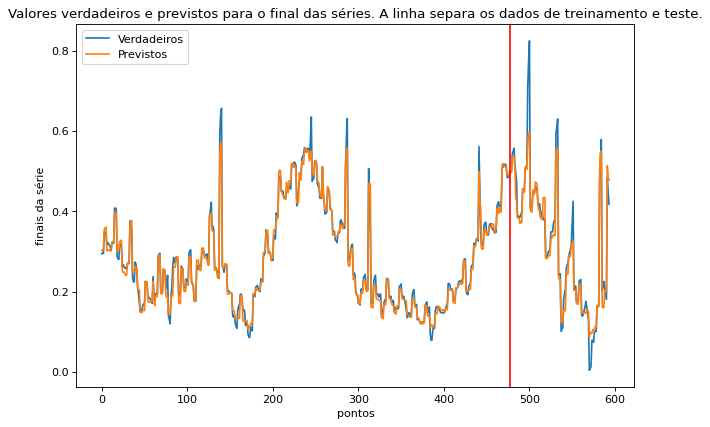

In [2]:
#EXTRA: como adaptar para uma rede recorrente de 2 camadas.
#cria uma rede recorrente com 2 camadas recorrentes e 2 densas.
def cria_RNN_2_2(hidden_units, dense_units, input_shape, activation):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.SimpleRNN(hidden_units, input_shape=input_shape, 
                        activation=activation[0],return_sequences=True))
    model.add(tf.keras.layers.SimpleRNN(int(hidden_units/2), activation=activation[0]))
    model.add(tf.keras.layers.Dense(units=dense_units, activation=activation[1]))
    model.add(tf.keras.layers.Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model    

model = cria_RNN_2_2(hidden_units=9, dense_units=Npred, input_shape=(Npontos-Npred,1), 
                   activation=['relu', 'sigmoid'])
print(model.summary())
print('len= ',trainY.shape)
history=model.fit(trainX, trainY , epochs=300, batch_size=1, verbose=0)
plt.figure()
plt.plot(history.history['loss'],'k')
plt.yscale('log')
plt.legend(['loss'])

# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
train_msre=np.mean((train_predict-trainY)**2)
test_msre=np.mean((test_predict-testY)**2)
print('train erro= ',train_msre);print('test erro= ',test_msre)

# gráfico dos valores verdadeiros com os previstos
finais_verdadeiros = np.append(trainY, testY)
predictions = np.append(train_predict, test_predict)
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(finais_verdadeiros)
plt.plot(predictions)
plt.axvline(len(trainY)*Npred, color='r')
plt.legend(['Verdadeiros', 'Previstos'])
plt.xlabel('pontos')
plt.ylabel('finais da série')
plt.title('Valores verdadeiros e previstos para o final das séries. A linha separa os dados de treinamento e teste.')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 9)                 99        
                                                                 
 dense_3 (Dense)             (None, 3)                 30        
                                                                 
 dense_4 (Dense)             (None, 3)                 12        
                                                                 
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________
None
train erro=  0.00042653347610256085
test erro=  0.0017120086613742146


Text(0.5, 1.0, 'Valores verdadeiros e previstos para o final das séries. A linha separa os dados de treinamento e teste.')

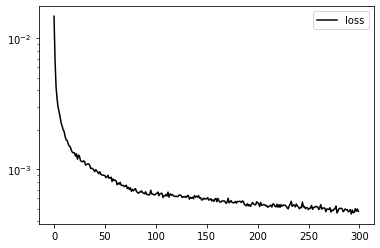

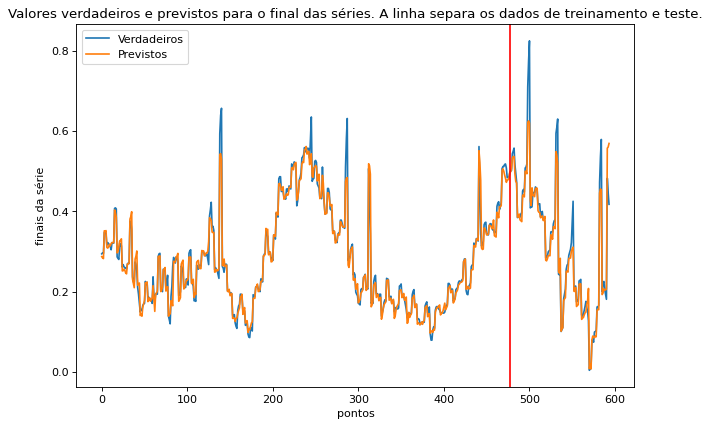

In [3]:
#EXTRA2: learning rate e 2 camadas densas com relu
#cria uma rede recorrente com 1 camada recorrente e 2 densa2.
def cria_RNN(hidden_units, dense_units, input_shape, activation):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.SimpleRNN(hidden_units, input_shape=input_shape, 
                        activation=activation[0]))
    model.add(tf.keras.layers.Dense(units=dense_units, activation=activation[1]))
    model.add(tf.keras.layers.Dense(units=dense_units, activation=activation[2]))
    opt=tf.keras.optimizers.Adam(learning_rate=0.0005)    
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model
model = cria_RNN(hidden_units=9, dense_units=Npred, 
      input_shape=(Npontos-Npred,1), activation=['tanh','tanh', 'tanh'])
print(model.summary())
#treina a rede e mostra o gráfico do loss
history=model.fit(trainX, trainY , epochs=300, batch_size=1, verbose=0)
plt.figure()
plt.plot(history.history['loss'],'k')
plt.yscale('log')
plt.legend(['loss'])

#faz previsões e calcula os erros
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
train_msre=np.mean((train_predict-trainY)**2)
test_msre=np.mean((test_predict-testY)**2)
print('train erro= ',train_msre);print('test erro= ',test_msre)

# gráfico dos valores verdadeiros com os previstos
finais_verdadeiros = np.append(trainY, testY)
predictions = np.append(train_predict, test_predict)
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(finais_verdadeiros)
plt.plot(predictions)
plt.axvline(len(trainY)*Npred, color='r')
plt.legend(['Verdadeiros', 'Previstos'])
plt.xlabel('pontos')
plt.ylabel('finais da série')
plt.title('Valores verdadeiros e previstos para o final das séries. A linha separa os dados de treinamento e teste.')